# Paths between BP solutions

Given an instance

- construct a basis $\mathcal{B}=\{v_1,...,v_k\}$ of seaweeds
- find 2 distinct solutions $x_1,x_2$ with BP
- build $x=x_1\oplus x_2$
- find a path of "small" jumps from $0$ to $x$: $x=\alpha^i v_i$
- plot the distortion of of the codeword along the path from $x_1$ to $x_2$

In [123]:
include("../code/bp_full.jl")
include("../code/seaweed.jl")
using OffsetArrays

Build graph and remove some factors

In [86]:
m = factorial(5)*11*2
R = 0.8/3
f3 = 1 - 3R
n = round(Int, 3m/(2+f3))
@show n
Λ = [0,1-f3,f3]
K = [0,0,1]
nedges = 3m
b = round(Int, 3*sqrt(n))

n = 3600


240

In [87]:
Ht = ldpc_matrix(n, m, nedges, Λ, K)
# remove b factors
Ht = Ht[:,1:end-b]
dropzeros!(Ht)
H = sparse(permutedims(copy(Ht)));

### Build a first basis with gaussian elimination

This will in general not be sparse. We just use it to compute the size of the space of solutions, i.e. the number of needed independent seaweeds.

In [130]:
BB1, indep1 = findbasis(H)
@assert iszero(H*BB1.%2)
dim1 = length(indep1)

1200

In [131]:
BB2, indep2 = findbasis(H)
@assert iszero(H*BB2.%2)
dim2 = length(indep2)

1200

## Build the basis B using seaweeds

In [96]:
fg = FactorGraphGF2(Int.(H))
nsw = 5*fg.n
B, nsteps = seaweed_basis(nsw, fg, dim)
println("Basis found after trying ", nsteps, " seaweeds")

Progress: 100%|█████████████████████████████████████████| Time: 0:22:32


Basis found after trying 3588 seaweeds


### Find 2 BP solutions

In [89]:
# external field strength
HH = 0.5
s = rand((-1,1), n)
efield = [(exp(ss*HH),exp(-ss*HH)) for ss in s]
bp = BPFull(H)
bp.efield .= efield;

Start from two different random initialization to encourage BP to find different solutions

In [132]:
bp1 = deepcopy(bp)
bp2 = deepcopy(bp);

Use some reinforcement, too

In [133]:
nunsat1,_,dist1 = decimate!(bp1, efield, indep1, s;  tol=1e-4)

Trial 1 of 1: 0 unsat. Dist = 0.216


(0, 0.5688888888888889, 0.21555555555555556)

In [134]:
nunsat2,_,dist2 = decimate!(bp2, efield, indep2, s;  tol=1e-4)

Trial 1 of 1: 0 unsat. Dist = 0.214


(0, 0.5711111111111111, 0.21444444444444444)

In [135]:
x1 = argmax.(bp1.belief) .== 2
@assert sum(H*x1 .% 2) == 0
x2 = argmax.(bp2.belief) .== 2
@assert sum(H*x2 .% 2) == 0

Compute $x=x_1\oplus x_2$ and check that they are indeed two different codewords

In [138]:
x = xor.(x1,x2)
@assert sum(H*x .% 2) == 0
sum(x)

266

Compression performance is not great because we removed quite a lot of checks

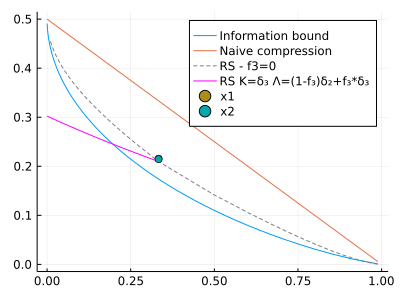

In [139]:
Rtrue = dim/n
pl = plot_rdb()
scatter!(pl, [Rtrue], [dist1], label="x1")
scatter!(pl, [Rtrue], [dist2], label="x2")
plot(pl, size=(400,300))

### Find a path of small jumps
To find the expansion coefficients $\alpha$ of $x$ on the basis, solve $B\alpha=x$:
- Build $A=[B |x]$
- Reduce it with row operations to 
                                   |   | |
                                   | I |a|
                                   |___|_|
                                   | 0 |0|

In [140]:
A = ([B x])
A,dep = gfrrefGF2!(A)
dropzeros!(A)
alpha = A[dep,end]
@assert B*alpha.%2 == x
sum(alpha)

88

Build path from $0$ to $x$ by accumulating each small jump via a $\oplus$ operation

In [141]:
function build_path(B, alpha, x)
    n = length(x)
    nz_alpha = findall(alpha)
    P = falses(n,length(nz_alpha)+1)
    for (i,a) in enumerate(nz_alpha)
        P[:,i+1] .= xor.(P[:,i], B[:,a])
    end
    @assert P[:,end] == x
    P
end

build_path (generic function with 1 method)

In [142]:
P = build_path(B, alpha, x)
weight_jumps = sum(P, dims=1)

1×89 Matrix{Int64}:
 0  2  4  6  8  11  13  16  19  23  27  …  305  303  303  293  285  273  266

## Observe the distortion

To go from path $P=(0,\dots,x)$ to $P_1=(x_1,\dots,x_2)$, just do $P_1=P\oplus x_1$

In [143]:
P1 = reduce(hcat, [xor.(P[:,i],x1) for i in 1:size(P,2)])
@assert P1[:,end]==x2

In [144]:
d = [distortion(s, 1 .- 2p) for p in eachcol(P1)]
boltz_weight = exp.(-d*HH);

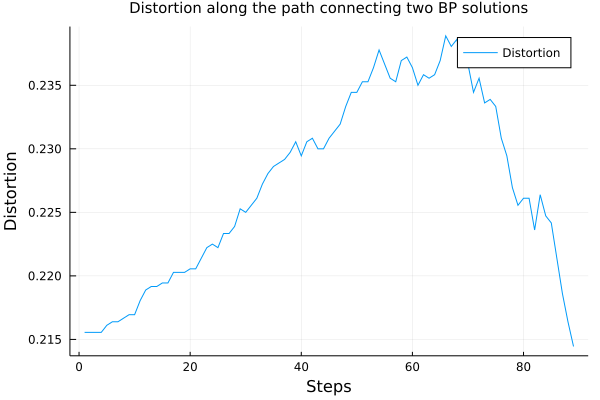

In [145]:
p1 = plot(d, label="Distortion"); xlabel!("Steps"); ylabel!("Distortion")
title!("Distortion along the path connecting two BP solutions")
plot!(titlefontsize=10)

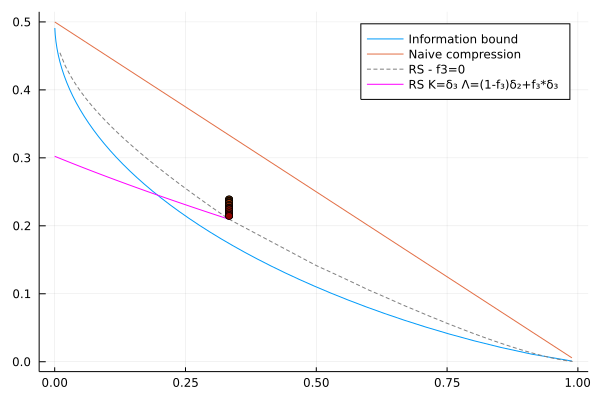

In [146]:
pl2 = plot_rdb()
colors = cgrad(:heat, length(d)+1, categorical = true)
for i in eachindex(d)
    scatter!(pl2, [Rtrue], [d[i]], mc=colors[i], label="")
end
# xlims!((0.30, 0.38)); ylims!((0.18,0.26))
pl2

In [120]:
maximum(d)

0.23